In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# https://www.tensorflow.org/tutorials/load_data/images # TUTORIAL CNN

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.11

import os
import pathlib
import pandas as pd
import numpy as np
from pywt import wavedec
import librosa
import random

from scipy.io import wavfile
from scipy.signal import find_peaks
import scipy.fft as fft
from scipy import signal

from sklearn.preprocessing import minmax_scale
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import IPython.display as ipd  # To play sound in the notebook

import seaborn as sns

import tensorflow as tf #2.9.2 --> 2.11

print(tf.__version__)
if (tf.__version__ == '2.9.2'):
  %pip install --upgrade tensorflow
  print(tf.__version__)


from tensorflow.keras import layers
from tensorflow.keras import models



Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.12.0


In [ ]:
datasets_path = '/content/drive/MyDrive/Mestrado/datasets/'

datasets = pd.read_csv(datasets_path + 'datasets.csv')
print(datasets.head())

               fname        label  speed
0  no_strip_70_0.WAV     no-strip     70
1  no_strip_80_0.WAV     no-strip     80
2  no_strip_90_0.WAV     no-strip     90
3    strip6_70_0.WAV   6-cm-strip     70
4    strip6_80_0.WAV   6-cm-strip     80


In [ ]:
print(datasets.label.unique())

[' no-strip' ' 6-cm-strip' ' 14-cm-strip']


**Get duration of all audios**

In [ ]:
for (file) in (datasets.fname):
  path = (datasets_path+file)
  duration = librosa.get_duration(filename=path)

labels = datasets.label.str.strip()
for (index, file) in zip(datasets.index, datasets.fname):
  duration = librosa.get_duration(filename=(datasets_path + file))
  datasets.loc[datasets.index==index,'duration'] = duration

print(datasets)

<ipython-input-5-742e42a2dadb>:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=path)
<ipython-input-5-742e42a2dadb>:7: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=(datasets_path + file))
<ipython-input-5-742e42a2dadb>:7: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=(datasets_path + file))


               fname         label  speed   duration
0  no_strip_70_0.WAV      no-strip     70  60.267392
1  no_strip_80_0.WAV      no-strip     80  63.082812
2  no_strip_90_0.WAV      no-strip     90  60.505397
3    strip6_70_0.WAV    6-cm-strip     70  65.329342
4    strip6_80_0.WAV    6-cm-strip     80  63.210522
5    strip6_90_0.WAV    6-cm-strip     90  61.707029
6   strip14_70_0.WAV   14-cm-strip     70  62.897052
7   strip14_80_0.WAV   14-cm-strip     80  63.553016
8   strip14_90_0.WAV   14-cm-strip     90  61.962449


In [ ]:
min_audio_time = datasets.duration.min()

print(min_audio_time)

60.26739229024943


**Applying Wavelet Transform**

In [ ]:
def split_data_equaly(data, samplerate, split_time_in_sec=2):
  data_length = len(data)
  data_time_in_sec = data_length/samplerate

  splitted_data_sample_count = int((data_length * split_time_in_sec) / data_time_in_sec)
  splitted_data = []

  split_count = int(data_time_in_sec/split_time_in_sec)
  splitted_data.append(data[0 : splitted_data_sample_count])
  for index in range(1, split_count):
    splitted = data[index * splitted_data_sample_count + 1 : index * splitted_data_sample_count + splitted_data_sample_count + 1]

    splitted_data.append(splitted)

  return splitted_data

In [ ]:
def read_wav(filename):
  samplerate, data = wavfile.read(datasets_path + filename)

  return samplerate, data

In [ ]:
class MasterData():
  def __init__(self, data, samplerate, name, label, speed, index):
    self.data = data#self.normalize_data(data)
    self.samplerate = samplerate
    self.name = name
    self.label = label.strip()
    self.speed = speed
    self.index = index
    self.tf_data = tf.data.Dataset.from_tensor_slices(data)

  def save_file(self, filepath):
    if not os.path.exists(filepath):
      os.mkdir(filepath)
      print("Directory " , filepath ,  " Created ")
    file_name = filepath + self.name

    wavfile.write(file_name, self.samplerate, self.data.astype(np.int16))

  def normalize_data(self, data):
    return minmax_scale(data, feature_range=(0,1))

<ipython-input-8-8e139b72dcb4>:2: WavFileWarning: Reached EOF prematurely; finished at 5315628 bytes, expected 10902150 bytes from header.
  samplerate, data = wavfile.read(datasets_path + filename)


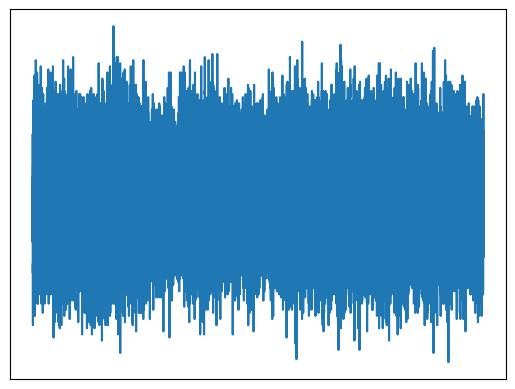

In [ ]:
for index_0, row_0 in datasets.iterrows():

  samplerate_0, data_0= read_wav(row_0.fname)
  data_1 = data_0[50000:319000]
  duration = len(data_1)/samplerate_0
  time = np.arange(0,duration,1/samplerate_0)

  dt = 10
  ticks = np.arange(0, 80 + dt, dt)
  plt.plot(time, data_1)
  plt.xticks([])
  plt.yticks([])
  # plt.ylabel('amplitude')
  # plt.xlabel('time (s)')
  plt.show()
  break;

[]

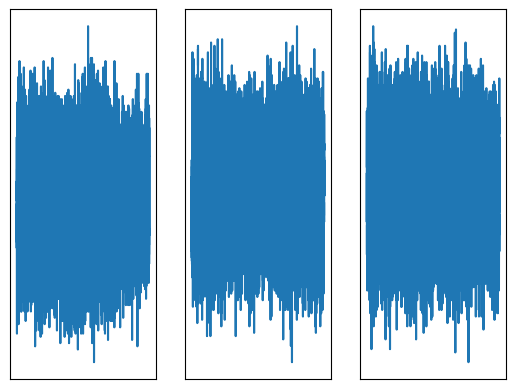

In [ ]:
rows = 1
cols = 3
n = rows * cols
fig, axes = plt.subplots(1, cols)


data_length = len(data_1)
data_time_in_sec = data_length/samplerate_0

splitted_data_sample_count = int((data_length) / 3)
splitted_data = []

split_count = 3
splitted_data.append(data_1[0 : splitted_data_sample_count])

data_2 = data_1[:splitted_data_sample_count]
data_3 = data_1[splitted_data_sample_count + 1: (2*splitted_data_sample_count) + 1]
data_4 = data_1[(2*splitted_data_sample_count) + 2 :]

ax = axes[0]
ax.plot(data_2)
ax.set_yticks([])
ax.set_xticks([])

ax = axes[1]
ax.plot(data_3)
ax.set_yticks([])
ax.set_xticks([])

ax = axes[2]
ax.plot(data_4)
ax.set_yticks([])
ax.set_xticks([])


In [ ]:
all_original_data = []
i = 0
for index, row in datasets.iterrows():
  samplerate, data = read_wav(row.fname)
  audio_binary = tf.io.read_file(datasets_path+row.fname)

  for splitted_data in split_data_equaly(data, samplerate, split_time_in_sec=1):
    obj = MasterData(splitted_data, samplerate, 'sacdm_original_' + row.fname, row.label, row.speed, i)
    i = i+1
    all_original_data.append(obj)

<ipython-input-8-8e139b72dcb4>:2: WavFileWarning: Reached EOF prematurely; finished at 5315628 bytes, expected 10902150 bytes from header.
  samplerate, data = wavfile.read(datasets_path + filename)
<ipython-input-8-8e139b72dcb4>:2: WavFileWarning: Reached EOF prematurely; finished at 5563948 bytes, expected 11242770 bytes from header.
  samplerate, data = wavfile.read(datasets_path + filename)
<ipython-input-8-8e139b72dcb4>:2: WavFileWarning: Reached EOF prematurely; finished at 5336620 bytes, expected 10878794 bytes from header.
  samplerate, data = wavfile.read(datasets_path + filename)
<ipython-input-8-8e139b72dcb4>:2: WavFileWarning: Reached EOF prematurely; finished at 5762092 bytes, expected 11688742 bytes from header.
  samplerate, data = wavfile.read(datasets_path + filename)
<ipython-input-8-8e139b72dcb4>:2: WavFileWarning: Reached EOF prematurely; finished at 5575212 bytes, expected 11351290 bytes from header.
  samplerate, data = wavfile.read(datasets_path + filename)
<ipyt

In [ ]:
def get_spectrogram(waveform, audio_frequency=44100):
  # Zero-padding for an audio waveform with less than 16,000 samples.

  input_len = audio_frequency
  waveform = waveform[:input_len]
  zero_padding = np.zeros(
      audio_frequency - waveform.shape[0],
      dtype=float)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  equal_length_tf = tf.constant(equal_length)
  spectrogram = tf.signal.stft(
      equal_length_tf, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Let's plot a few wave forms

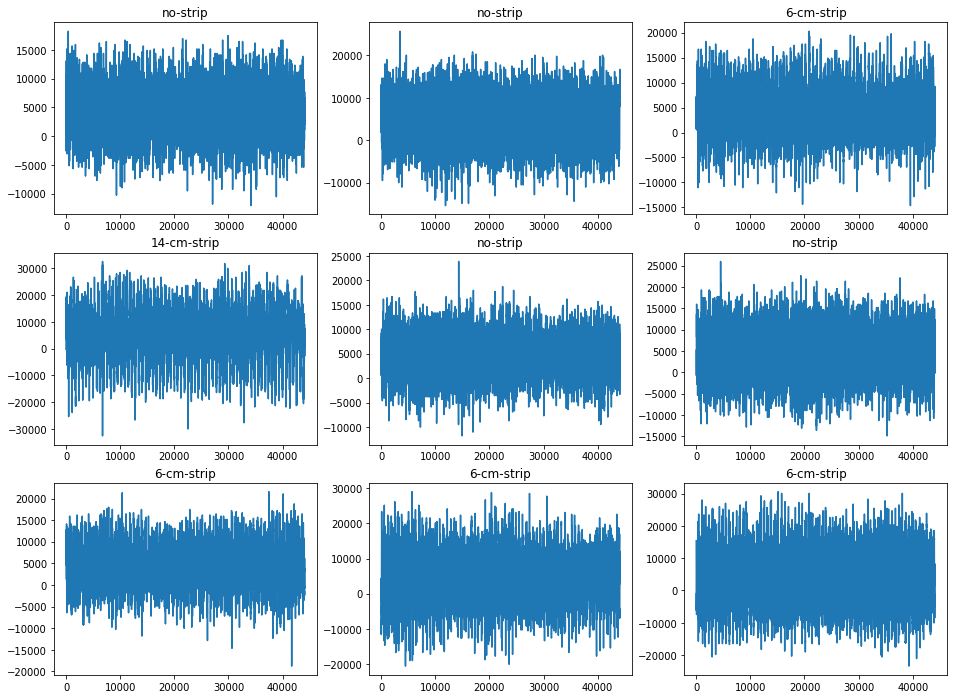

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 12))

# Get "n" random items to plot
for i, audio in enumerate(random.choices(all_original_data, k=n)):
  # print(np.min(audio.data), np.max(audio.data))
  # audio_as_float = to_float(audio)
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  # print(audio.numpy().astype(np.string_))
  ax.plot(audio.data)
  # ax.set_yticks(np.arange(-2000, 2000))
  # ax.set_yticks(np.arange(-1, 1, .1))
  # sacdm_audio = apply_sacdm(audio.numpy(), 1000)
  # ax.plot(sacdm_audio)
  # label = audio.label.numpy().decode('utf-8')
  ax.set_title(audio.label)

# plt.show()


In [ ]:
#PEGA O AUDIO E O INDICE DO LABEL DO OBJETO MASTERDATA
def get_spectrogram_and_label_id(audio, label):
  # spectrogram = get_spectrogram(audio) #TODO: apenas passando o audio pois o spectrograma sera gerado dps
  spectrogram = audio
  label_id = list(labels).index(label)
  # label_id = tf.argmax(label == labels)
  # label_id = tf.constant(list(labels).index(label))
  # print(label, label_id)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = [get_spectrogram_and_label_id(x.data, x.label) for x in all_original_data]

In [ ]:
# rows = 3
# cols = 3
# n = rows*cols
# fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

# for i, (spectrogram, label_id) in enumerate(random.choices(spectrogram_ds, k=n)):
#   r = i // cols
#   c = i % cols
#   ax = axes[r][c]
#   plot_spectrogram((spectrogram), ax)
#   ax.set_title(labels[label_id])
#   ax.axis('off')

# plt.show()

In [ ]:
dataset_csv_path = datasets_path + 'sacdm_original_splitted';
data_dir = pathlib.Path(dataset_csv_path)

labels = list(set(labels))
print(labels)

['no-strip', '14-cm-strip', '6-cm-strip']


In [ ]:
# filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
# filenames = tf.random.shuffle(filenames)
# num_samples = len(filenames)
# print('Number of total examples:', num_samples)
# print('Number of examples per label:',
#       len(tf.io.gfile.listdir(str(data_dir/labels[0]))))
# print('Example file tensor:', filenames[0])
num_samples = len(all_original_data)
per_label = int((num_samples / len(labels)))
print('Number of total sacdm samples:', num_samples)
print('Number of examples per label:', per_label)

Number of total sacdm samples: 558
Number of examples per label: 186


In [ ]:
def split_train_val_test(data, train_percentage=0.8):
  data_size = len(data)
  train_size = int(data_size * train_percentage)
  val_size = 0
  test_size = 0

  remaining_size = int(data_size - train_size)

  if (remaining_size % 2 == 0):
    test_size = int(remaining_size / 2)
    val_size = int(remaining_size / 2)
  else:
    test_size = int(remaining_size // 2)
    val_size = remaining_size - test_size

  return (data[:train_size], data[train_size: train_size + val_size], data[(-1)*test_size:])

In [ ]:
# train_data = all_original_data[:72]
# val_data = all_original_data[72: 72 + 9]
# test_data = all_original_data[-9:]
train_data, val_data, test_data = split_train_val_test(all_original_data)

audio_frequency = 44100

print('Training set size', len(train_data))
print('Validation set size', len(val_data))
print('Test set size', len(test_data))

Training set size 446
Validation set size 56
Test set size 56


## **CNN**

In [ ]:
# def plot_save_spectrogram_file(spectrogram, path_label, fig_index):
#   fig, ax = plt.subplots( nrows=1, ncols=1 )

#   plot_spectrogram(spectrogram, ax)
#   plt.axis('off')
#   extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

#   fig.savefig(datasets_path+'datasets_imgs/'+path_label+'/'+str(fig_index)+'.png', bbox_inches=extent)
#   plt.close()
def plot_save_spectrogram_file(data, path_label, fig_index):
  fig, ax = plt.subplots( nrows=1, ncols=1 )

  freq, time, Spec_x = signal.spectrogram(data, 44100, window=signal.windows.hann(300), nperseg=300, noverlap=50)
  # freq, time, Spec_x = signal.spectrogram(data, 44100)

  ax.pcolormesh(time, freq, 10*np.log10(Spec_x), shading='gouraud')
  # plt.ylabel('Frequency [Hz]')
  # plt.xlabel('Time [sec]')
  # plt.show()

  plt.axis('off')
  extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

  fig.savefig(datasets_path+'datasets_imgs_audio/'+path_label+'/'+str(fig_index)+'.png', bbox_inches=extent)
  plt.close()

In [ ]:
for i, (spectrogram, label_id) in enumerate(random.choices(spectrogram_ds, k=len(all_original_data))):
  plot_save_spectrogram_file(spectrogram, labels[label_id], i)


44100


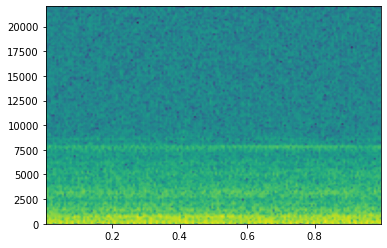

In [ ]:
for i, audio in enumerate(random.choices(all_original_data, k=1)):
  fig, ax = plt.subplots( nrows=1, ncols=1)
  print(len(audio.data))

  freq, time, Spec_x = signal.spectrogram(audio.data, audio_frequency, window=signal.windows.hann(300), nperseg=300, noverlap=50, scaling='density')
  # freq, time, Spec_x = signal.spectrogram(audio.data, audio_frequency)
  ax.pcolormesh(time, freq, 10*np.log10(Spec_x), shading='gouraud')

In [ ]:
# train_ds = tf.data.Dataset.from_tensor_slices(data_ds[:108])
# val_ds = tf.data.Dataset.from_tensor_slices(data_ds[108: 108 + 14])
# test_ds = tf.data.Dataset.from_tensor_slices(data_ds[-14:])

# batch_size = 64

# train_ds = train_ds.batch(batch_size)
# val_ds = val_ds.batch(batch_size)

In [ ]:
import pathlib
dataset_url = datasets_path+'datasets_imgs_audio'
data_dir = pathlib.Path(dataset_url)
count = len(list(data_dir.glob('*/*.png')))
print('Total number of images is', count)

Total number of images is 558


In [ ]:
batch_size = 32
img_height = 150
img_width = 150
num_channels = 3

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle = True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 558 files belonging to 3 classes.
Using 447 files for training.


In [ ]:
val_ds_0 = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle = True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 558 files belonging to 3 classes.
Using 111 files for validation.


In [ ]:
test_ds, val_ds = tf.keras.utils.split_dataset(val_ds_0, left_size=0.5, shuffle=True)

# for i, (a,b) in enumerate(test_ds):
#   print(b)

print('Batches validation base-->', len(list(val_ds_0.unbatch().as_numpy_iterator())))
print('Batches for training -->', len(list(train_ds.unbatch().as_numpy_iterator())))
print('Batches for testing -->', len(list(test_ds.unbatch().as_numpy_iterator())))
print('Batches for validating -->', len(list(val_ds.unbatch().as_numpy_iterator())))

Batches validation base--> 111
Batches for training --> 447
Batches for testing --> 56
Batches for validating --> 55


In [ ]:
class_names = train_ds.class_names
print(class_names)

['14-cm-strip', '6-cm-strip', 'no-strip']


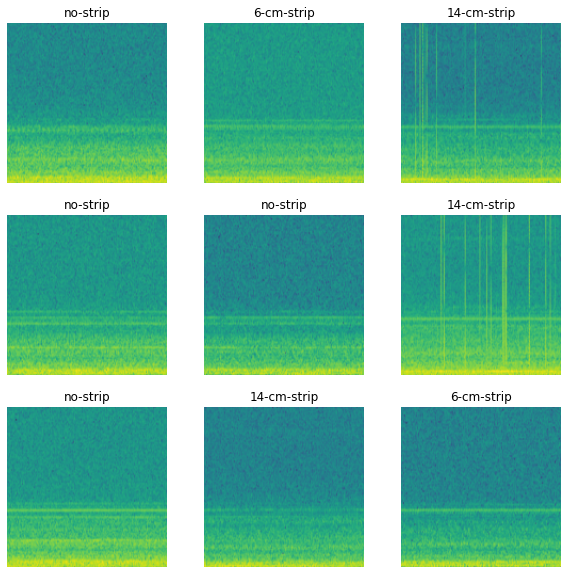

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
# val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# image_batch, labels_batch = next(iter(train_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

0.09378938 0.8823972


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#print(type(test_ds), list(val_ds.as_numpy_iterator()))

In [ ]:
num_classes = 3

## MODEL TF
# model = tf.keras.Sequential([
#   tf.keras.layers.Rescaling(1./255),
#   tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(num_classes)
# ])

# # MODEL LENET
# model = tf.keras.Sequential([
#   tf.keras.layers.Rescaling(1./255),
#   tf.keras.layers.Conv2D(filters=6, kernel_size=(5,5), activation='tanh', input_shape=(img_height, img_width, num_channels)),
#   tf.keras.layers.AveragePooling2D(2),
#   # tf.keras.layers.Activation('relu'),
#   tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5), activation='tanh'),
#   tf.keras.layers.AveragePooling2D(2),
#   # tf.keras.layers.Activation('relu'),
#   tf.keras.layers.Conv2D(filters=120, kernel_size=(5,5), activation='tanh'),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(84, activation='tanh'),
#   tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

# # MODEL KAGGLE
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    #first_convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(img_height, img_width, num_channels)),
    tf.keras.layers.MaxPooling2D(2, 2),
    #second_convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #third_convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #fourth_convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(
  optimizer='adam',
  # optimizer=tf.keras.optimizers.Adam(),
  loss=tf.losses.SparseCategoricalCrossentropy(),
  # loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
EPOCHS = 16
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=32,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5)
)

Epoch 1/16
14/14 [==============================] - 12s 735ms/step - loss: 1.1044 - accuracy: 0.3736 - val_loss: 1.1057 - val_accuracy: 0.2909
Epoch 2/16
14/14 [==============================] - 10s 713ms/step - loss: 1.0986 - accuracy: 0.3289 - val_loss: 1.0992 - val_accuracy: 0.2909
Epoch 3/16
14/14 [==============================] - 13s 974ms/step - loss: 1.0945 - accuracy: 0.3647 - val_loss: 1.0942 - val_accuracy: 0.3091
Epoch 4/16
14/14 [==============================] - 10s 716ms/step - loss: 1.0605 - accuracy: 0.4251 - val_loss: 1.0794 - val_accuracy: 0.3636
Epoch 5/16
14/14 [==============================] - 10s 711ms/step - loss: 1.0199 - accuracy: 0.4676 - val_loss: 1.0571 - val_accuracy: 0.4000
Epoch 6/16
14/14 [==============================] - 10s 693ms/step - loss: 0.9769 - accuracy: 0.5280 - val_loss: 0.9803 - val_accuracy: 0.4909
Epoch 7/16
14/14 [==============================] - 10s 713ms/step - loss: 0.9097 - accuracy: 0.5034 - val_loss: 0.9077 - val_accuracy: 0.4364

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 64)       

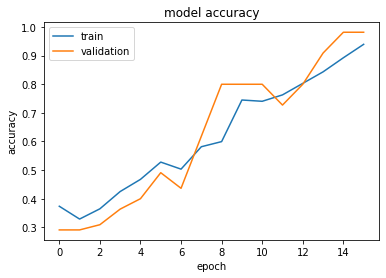

In [ ]:
# Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

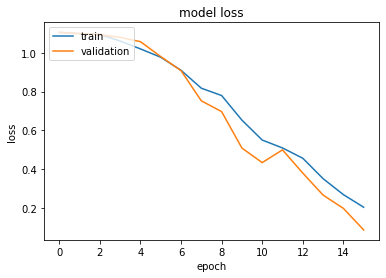

In [ ]:
# Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
accuracy = model.evaluate(val_ds)

2/2 [==============================] - 0s 148ms/step - loss: 0.0872 - accuracy: 0.9818


In [ ]:
print('Model accuracy', accuracy[1])

Model accuracy 0.9818181991577148


### Predicting

In [ ]:
predictions = model.predict(test_ds)

2/2 [==============================] - 1s 155ms/step


In [ ]:
print(predictions[0])
predicted_label_id = np.argmax(predictions[0])
print(class_names[predicted_label_id])

[0.00115029 0.00291514 0.9959345 ]
no-strip


In [ ]:
concated = tf.concat([list(test_ds)[0][1],list(test_ds)[1][1]], 0)
print(concated)
print(np.argmax(predictions, axis=1))

tf.Tensor(
[2 0 1 2 1 2 0 0 0 1 2 1 1 1 0 0 1 0 1 1 1 2 0 0 2 2 1 2 2 1 1 2 1 1 1 2 0
 1 0 0 2 1 2 2 0 2 2 0 2 0 0 2 0 2 2 1], shape=(56,), dtype=int32)
[2 0 1 2 1 2 0 0 0 1 2 1 1 1 0 0 1 0 1 1 1 2 0 0 2 2 0 2 2 1 1 2 1 1 1 2 0
 1 0 0 2 1 2 2 0 2 2 0 2 0 0 2 0 2 2 1]


### Confusion Matrix

n Test_Accuracy:- 0.9818181991577148
[2 0 1 2 1 2 0 0 0 1 2 1 1 1 0 0 1 0 1 1 1 2 0 0 2 2 0 2 2 1 1 2 1 1 1 2 0
 1 0 0 2 1 2 2 0 2 2 0 2 0 0 2 0 2 2 1]
confusion matrix


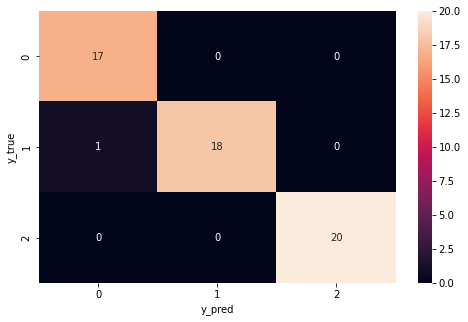

In [ ]:
print('n', 'Test_Accuracy:-', accuracy[1])
y_pred = np.argmax(predictions, axis=1)
print(y_pred)
# y_true = np.argmax(predictions, axis=1)
y_true = tf.concat([list(test_ds)[0][1],list(test_ds)[1][1]], 0)
print('confusion matrix')
# print(confusion_matrix(y_true, y_pred))
    #confusion matrix
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()